In [1]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as feat
import gc
import matplotlib.pyplot as plt
# from definitions import *

/home/hugo/mambaforge-pypy3/envs/env11/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
DATADIR = "/scratch2/hugo/ERA5"
CLIMSTOR = "/mnt/climstor/ecmwf/era5/raw"

def filenamescm(y, m, d):  # Naming conventions of the files on climstor (why are they so different?)
    return [f"{CLIMSTOR}/ML/data/{str(y)}/P{str(y)}{str(m).zfill(2)}{str(d).zfill(2)}_{str(h).zfill(2)}" for h in range(0, 24, 6)]
def filenamecp(y, m, d):
    return [f"{CLIMSTOR}/PL/data/an_pl_ERA5_{str(y)}-{str(m).zfill(2)}-{str(d).zfill(2)}.nc"]  # returns iterable to have same call signature as filenamescl(y, m, d)
def filenamegeneric(y, m, folder):
    return [f"{DATADIR}/{folder}/{y}{str(m).zfill(2)}.nc"]

def _fn(date, which):
    if which == "ML":
        return filenamescm(date.year, date.month, date.day)
    elif which == "PL":
        return filenamecp(date.year, date.month, date.day)
    else:
        return filenamegeneric(date.year, date.month, which)
    
def fn(date, which):  # instead takes pandas.timestamp (or iterable of _) as input
    if isinstance(date, (list, np.ndarray, pd.DatetimeIndex)):
        filenames = []
        for d in date:
            filenames.extend(_fn(d, which))
        return filenames
    elif isinstance(date, pd.Timestamp):
        return _fn(date, which)
    else:
        raise RuntimeError(f"Invalid type : {type(date)}")

RADIUS = 6.371e6  # m
OMEGA = 7.2921e-5  # rad.s-1
KAPPA = 0.2854
R_SPECIFIC_AIR = 287.0500676

def degcos(x):
    return np.cos(x / 180 * np.pi)
def degsin(x):
    return np.sin(x / 180 * np.pi)

DATERANGEPL = pd.date_range("19590101", "20020331")
YEARSPL = np.unique(DATERANGEPL.year)
DATERANGEML = pd.date_range("19770101", "20211231")
WINDBINS = np.arange(0, 25, 2)
LATBINS = np.arange(15, 75, 2.5)
LONBINS = np.arange(-90, 30, 3)
DEPBINS = np.arange(-25, 26, 1.5)

In [3]:
# ERA5
files = np.asarray([filenamegeneric(y, m, "Woollings_daily") for y in YEARSPL for m in range(1, 13)]).flatten()
da_5 = xr.open_mfdataset(files, concat_dim="time", combine='nested', engine="netcdf4")["u"].isel(lon=0)
da_5 = da_5.assign_coords({"time": da_5.time - pd.Timedelta(9, "hours")})
da_5 = da_5.sel(time=DATERANGEPL).reset_coords("lon", drop=True)

In [4]:
# ERA 40
da_40 = xr.open_dataset("/scratch2/hugo/ERA40/Woollings.nc")["u"].interp(lat=np.arange(15, 76, 2.5))
da_40 = da_40.assign_coords({"time": da_40.time - pd.Timedelta(9, "hours")})
da_40 = da_40.sel(time=DATERANGEPL)

Text(0.5, 1.0, 'Diff')

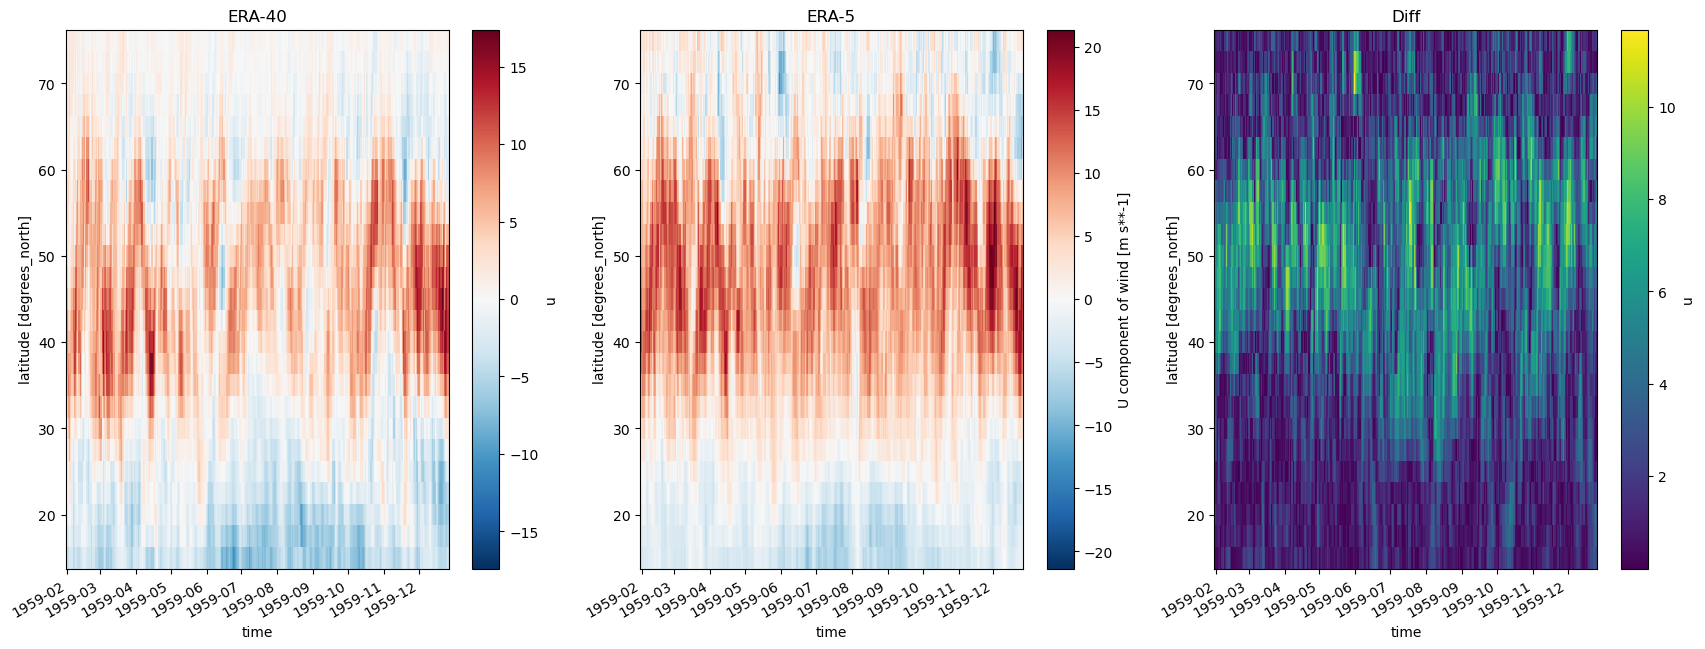

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
plt_kwargs = {}
thesetimes = np.arange(30, 360)
da_40.transpose().isel(time=thesetimes).plot(ax=axes[0], **plt_kwargs)
da_5.interp(lat=np.arange(15, 76, 2.5)).transpose().isel(time=thesetimes).plot(ax=axes[1], **plt_kwargs)
np.abs(da_40 - da_5.interp(lat=np.arange(15, 76, 2.5))).transpose().isel(time=thesetimes).plot(ax=axes[2], **plt_kwargs)
axes[0].set_title("ERA-40")
axes[1].set_title("ERA-5")
axes[2].set_title("Diff")

## 2d wind

In [31]:
da_5_2d = xr.open_dataarray(f"/scratch2/hugo/ERA5/Wind/195901.nc").sel(level=[700, 775, 850, 925]).mean(dim="level").resample(time="1D").mean()
da_40_2d = xr.open_dataset(f"/scratch2/hugo/ERA40/UandVregridded2.nc")["u"]

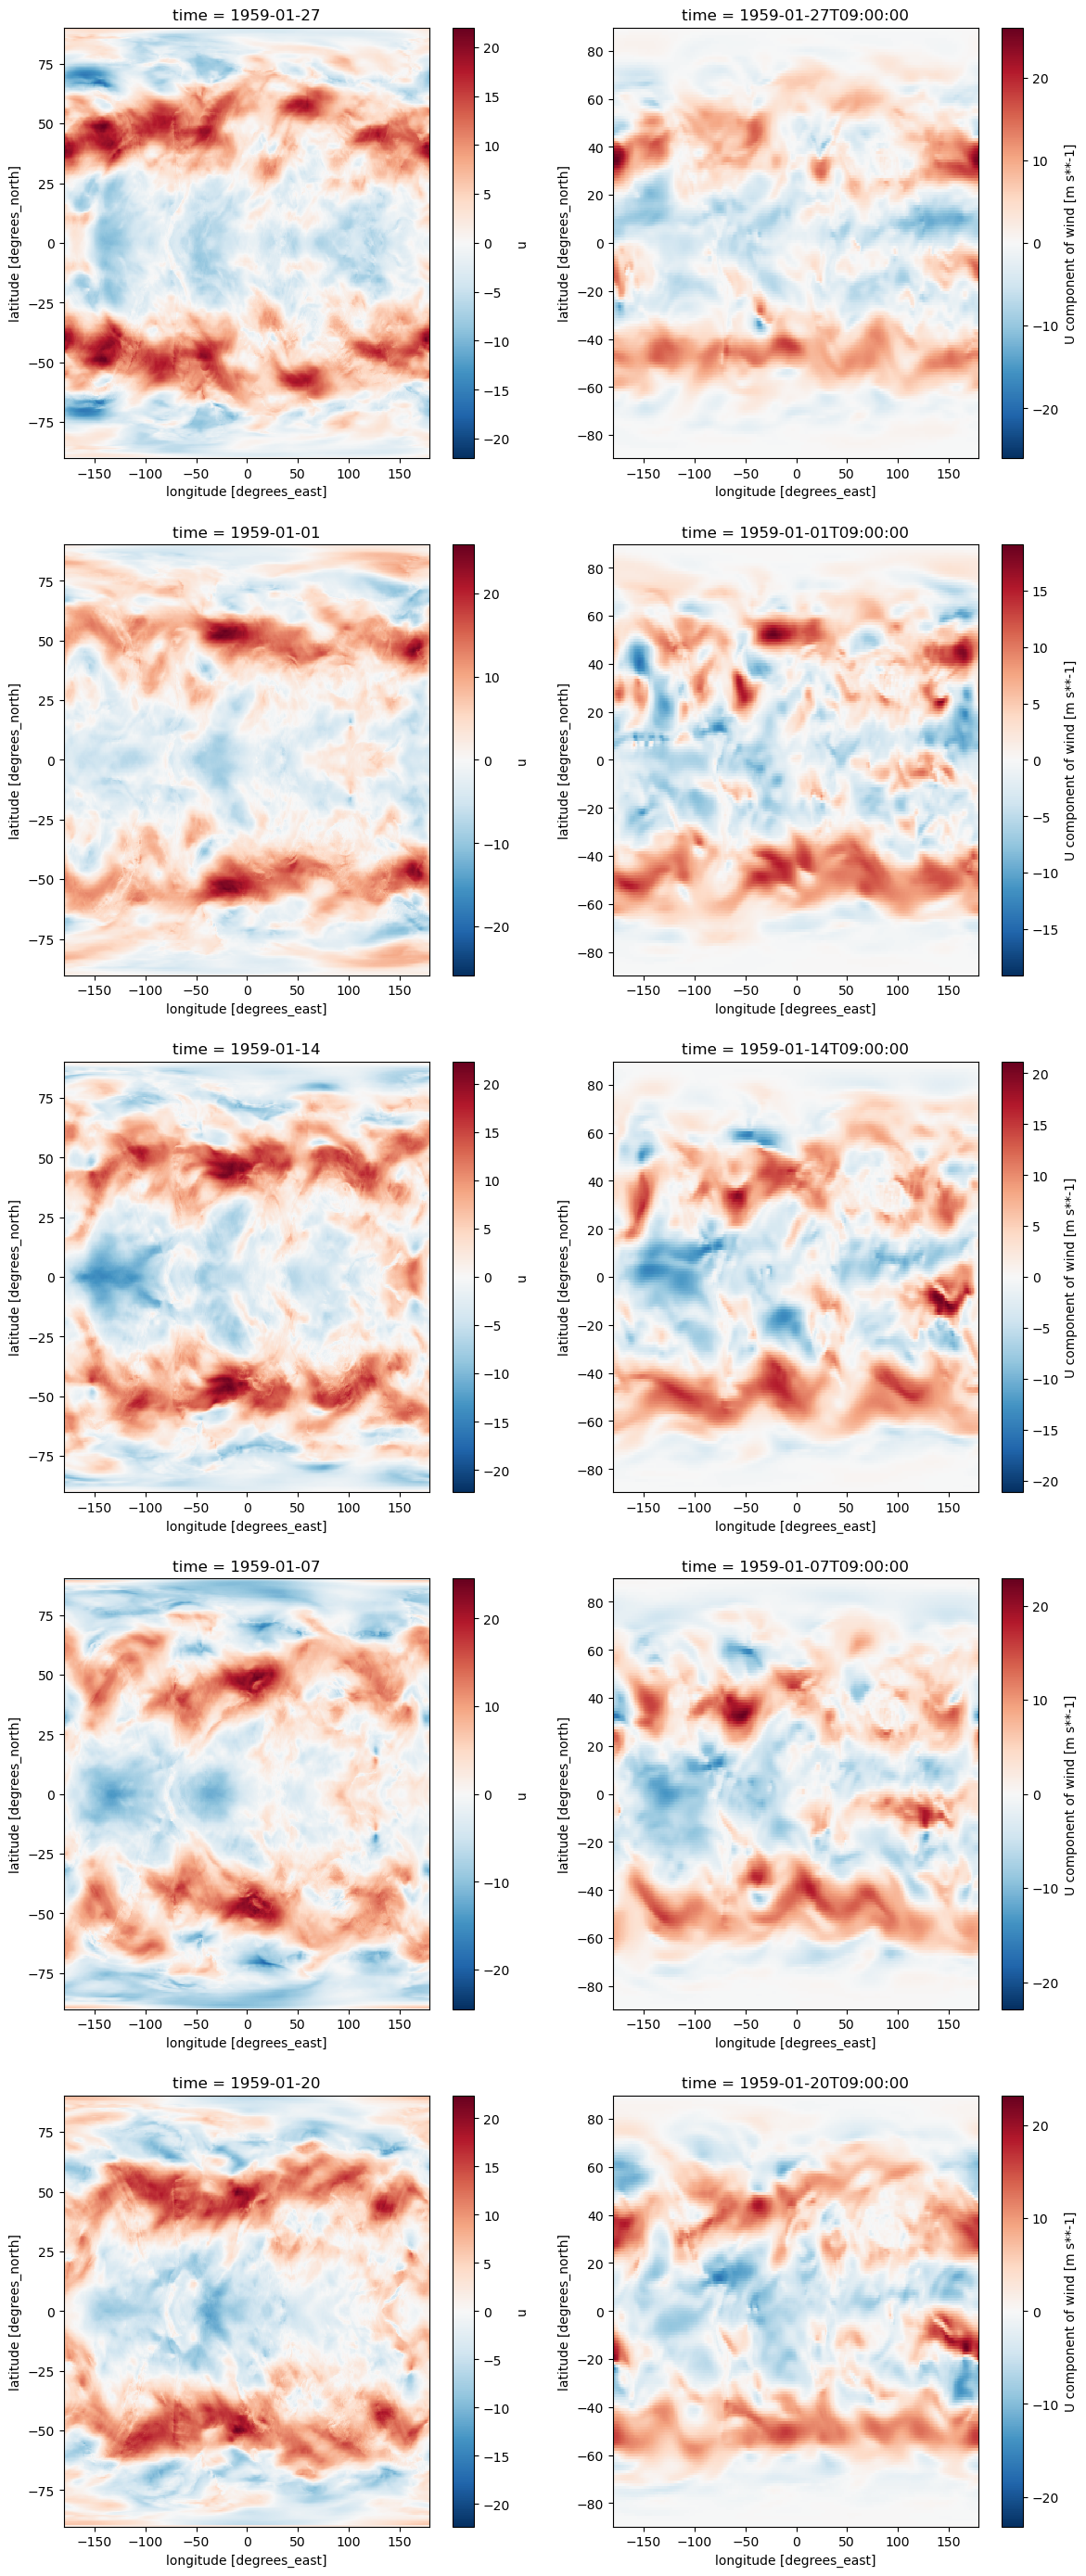

In [34]:
fig, axes = plt.subplots(5, 2, figsize=(14, 35))
j = np.random.randint(len(da_5_2d.time), size=5)
for i in range(5):
    da_5_2d.isel(time=j[i]).plot(ax=axes[i, 0])
    da_40_2d.isel(time=396 + j[i]).plot(ax=axes[i, 1])

In [38]:
da_5_2d_climstor = xr.open_mfdataset(fn(DATERANGEPL[0], "PL"), engine="scipy")

In [ ]:
da_5_2d_climstor